#### Importing Libraries and Dataset

In [68]:
import numpy as np                                          # Importing libraries...
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [69]:
dataset = pd.read_csv("E:/Downloads/Customer-churn.csv")       # Importing the dataset...
dataset.shape

(7043, 21)

In [70]:
dataset.sample(5)       # Calling sample dataset...

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6823,7009-LGECI,Female,0,No,No,4,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),50.55,235.65,No
458,4237-CLSMM,Male,0,Yes,No,2,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.00,38,No
5581,5271-YNWVR,Male,0,Yes,Yes,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,113.15,7856,Yes
3605,8148-BPLZQ,Male,0,No,No,34,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,49.80,1734.2,No
69,7410-OIEDU,Male,0,No,No,10,Yes,No,Fiber optic,Yes,...,Yes,No,No,No,Month-to-month,Yes,Mailed check,79.85,887.35,No


#### Data Preprocessing and Pipelining

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin     # BaseEstimator and TransformerMixin called...
class RemoveColumns(BaseEstimator, TransformerMixin):         # class to remove columns...
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.drop(columns="customerID", axis=1)
        return X

In [72]:
class ConvertObjectToNumeric(BaseEstimator, TransformerMixin): # class to covert object to numeric data type...
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):       # Converting to Numeric data type of the TotalCharges column...
        pd.to_numeric(X.TotalCharges, errors="coerce")
        return X

    Using Pipelining concept and integrating the Pre-processing classes.

In [73]:
from sklearn.pipeline import Pipeline
Pipe = Pipeline([
    ("Remove", RemoveColumns()),
    ("Numeric", ConvertObjectToNumeric())
])
dataset = Pipe.fit_transform(dataset)      # Fit and Transforming the dataset...

In [74]:
dataset = dataset[dataset.TotalCharges != " "]     # Removing the null value columns...
dataset.shape

(7032, 20)

#### Exploratory Data Analysis (EDA) and One-Hot Encoding

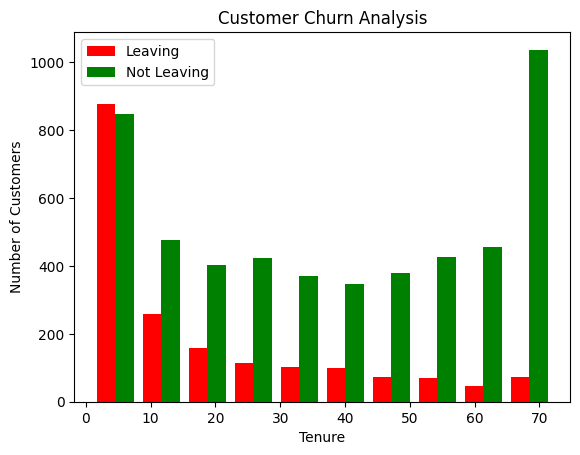

In [75]:
NotLeaving = dataset[dataset.Churn == "No"].tenure
Leaving = dataset[dataset.Churn == "Yes"].tenure
plt.xlabel("Tenure")
plt.ylabel("Number of Customers")
plt.title("Customer Churn Analysis")
plt.hist([Leaving, NotLeaving], color=["red", "green"], label=["Leaving", "Not Leaving"])
plt.legend()
plt.show()

    Intuitions-
1. If the customer has stayed for a long time, he/she does not leave the service.

    Replacing columns data for one-hot encoding.

In [76]:
dataset.replace("No internet service", "No", inplace=True)
dataset.replace("No phone service", "No", inplace=True)

One Hot Encoding of values...

In [77]:
YesNo = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in YesNo:
    dataset[col].replace({"Yes" : 1, "No" : 0}, inplace=True)
dataset['gender'].replace({"Female" : 1, "Male" : 0}, inplace=True)

In [78]:
dataset = pd.get_dummies(data=dataset, columns=["InternetService", "Contract", "PaymentMethod"])     # get_dummies function for one-hot encoding to uni-integer data type...

In [79]:
for col in dataset.columns:
    print(f'{col}: {dataset[col].dtype}')     # Format string technique...

gender: int64
SeniorCitizen: int64
Partner: int64
Dependents: int64
tenure: int64
PhoneService: int64
MultipleLines: int64
OnlineSecurity: int64
OnlineBackup: int64
DeviceProtection: int64
TechSupport: int64
StreamingTV: int64
StreamingMovies: int64
PaperlessBilling: int64
MonthlyCharges: float64
TotalCharges: object
Churn: int64
InternetService_DSL: uint8
InternetService_Fiber optic: uint8
InternetService_No: uint8
Contract_Month-to-month: uint8
Contract_One year: uint8
Contract_Two year: uint8
PaymentMethod_Bank transfer (automatic): uint8
PaymentMethod_Credit card (automatic): uint8
PaymentMethod_Electronic check: uint8
PaymentMethod_Mailed check: uint8


#### MinMax Scaling and Standardization

In [80]:
from sklearn.preprocessing import MinMaxScaler
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [81]:
MinMax = MinMaxScaler()
dataset[cols] = MinMax.fit_transform(dataset[cols])    # MinMax Scaling the columns...

#### Machine Learning and Splitting of Dataset into Train and Test dataset

In [82]:
Y = np.array(dataset['Churn']).reshape(-1, 1)
X = dataset.drop(columns="Churn", axis="columns")
print(X.shape, Y.shape)

(7032, 26) (7032, 1)


In [83]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25, random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(5274, 26) (1758, 26) (5274, 1) (1758, 1)


#### Deep Learning using Tensorflow and Keras Wrapper Library

In [84]:
Model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(26,), activation="relu"),  # Neurons: 20, Input of Shape: 26
    keras.layers.Dense(15, activation="relu"),                     # Neurons: 15, Input: 20
    keras.layers.Dense(1, activation="sigmoid")                    # Neurons: 1, Input: 15
])
Model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)
Model.fit(Xtrain, Ytrain, epochs=10)

Epoch 1/10
165/165 [==============================] - 0s 987us/step - loss: 0.5112 - accuracy: 0.7414
Epoch 2/10
165/165 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.7983
Epoch 3/10
165/165 [==============================] - 0s 873us/step - loss: 0.4245 - accuracy: 0.7998
Epoch 4/10
165/165 [==============================] - 0s 878us/step - loss: 0.4197 - accuracy: 0.8028
Epoch 5/10
165/165 [==============================] - 0s 879us/step - loss: 0.4163 - accuracy: 0.8057
Epoch 6/10
165/165 [==============================] - 0s 862us/step - loss: 0.4146 - accuracy: 0.8045
Epoch 7/10
165/165 [==============================] - 0s 1ms/step - loss: 0.4105 - accuracy: 0.8075
Epoch 8/10
165/165 [==============================] - 0s 893us/step - loss: 0.4086 - accuracy: 0.8058
Epoch 9/10
165/165 [==============================] - 0s 907us/step - loss: 0.4067 - accuracy: 0.8068
Epoch 10/10
165/165 [==============================] - 0s 882us/step - loss: 0.4050 - 

In [85]:
Model.evaluate(Xtest, Ytest)        # Evaluating the Testing dataset...

55/55 [==============================] - 0s 792us/step - loss: 0.4329 - accuracy: 0.7878


[0.43286487460136414, 0.7878270745277405]

In [86]:
predict = Model.predict(Xtest)       # Predicting the testing dataset...

55/55 [==============================] - 0s 634us/step


In [87]:
Ypred = []                  # Getting the Ypred value...
for element in predict:
    if element > 0.5:
        Ypred.append(1)
    else:
        Ypred.append(0)
print(len(Ypred))          # Shape same as the Ytest value (1758, 1)...

1758


    Getting the Classification report.

In [88]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1300
           1       0.60      0.54      0.57       458

    accuracy                           0.79      1758
   macro avg       0.72      0.71      0.72      1758
weighted avg       0.78      0.79      0.78      1758



    Defining Confusion Matrix:-
    1. True Negatives - Negatives (0) classified correctly.
    2. False Negatives - Negatives (0) classified incorrectly.
    3. False Positives - Positives (1) classified incorrectly.
    4. True Positives - Positives (1) classified correctly.

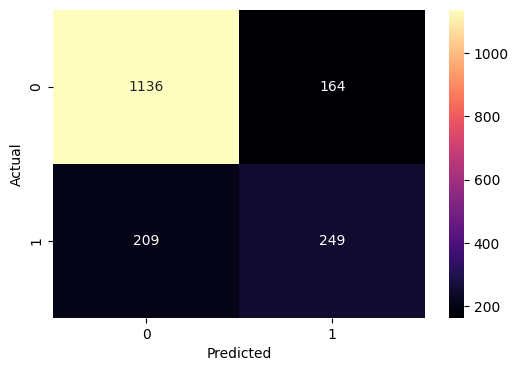

In [92]:
cm = tf.math.confusion_matrix(labels=Ytest, predictions=Ypred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, cmap="magma", annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()